Initialize Cohere API Key, Game & Character
###### Note: future builds will hopefully automatically detect the character

In [1]:
from langchain_cohere import ChatCohere
import getpass
import os
import json
with open(f'api.txt', errors='ignore') as f:
    api_key = f.read()
model = ChatCohere(cohere_api_key=api_key)

game = "elden_ring"
character = "Varre"
with open(f"{game}/characters/{character}/id.txt", errors='ignore') as f:
    conversation_id = f.read()
config = {"configurable": {"thread_id": conversation_id}}

c:\Users\ryanz\Desktop\LLM-Based-NPC\.venv\lib\site-packages\pydantic\_internal\_config.py:341: UserWarning: Valid config keys have changed in V2:
* 'allow_population_by_field_name' has been renamed to 'populate_by_name'
* 'smart_union' has been removed
  warnings.warn(message, UserWarning)


Initialize RAG for Long Term Conversational Memory
###### Note:

In [2]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_cohere import CohereEmbeddings
from langchain_chroma import Chroma
from langchain_core.embeddings import Embeddings
from uuid import uuid4
import chromadb

embeddings = CohereEmbeddings(cohere_api_key=api_key, model="embed-english-v3.0", user_agent='langchain')
vector_store = Chroma(
    collection_name=f"{character}_conversation_history",
    embedding_function=embeddings,
    persist_directory=f"{game}/characters/{character}/summary_vectordbs",
)
retriever = vector_store.as_retriever(
    search_kwargs={'k': 10}
)

In [3]:
rag_query = "Hello"
print(f"Rag Query: {rag_query}")
documents = retriever.invoke(rag_query)

for res in documents:
    print(f"{res.page_content}")

Rag Query: Hello


Number of requested results 10 is greater than number of elements in index 2, updating n_results = 2


A user greeted me, and I responded with a friendly introduction, revealing my name and allegiance to a fictional deity, Mohg. I also inquired about the user's identity, addressing them with a playful term, "my lambkin."
A Tarnished named Bob introduced himself, and I, Varre, acknowledged his name while also suggesting that identities in the Lands Between are fluid and ever-changing, especially for those seeking their fate. I implied that Bob, like many other Tarnished, is on a quest for power and enlightenment in this mysterious realm.


Connect conversation state to an external directory
###### Note: If the directory does not exist it will create one

In [4]:
import sqlite3
conn = sqlite3.connect(":memory:")

db_path = f"{game}/characters/{character}/state_db_with_rag_summaries/history.db"
conn = sqlite3.connect(db_path, check_same_thread=False)

from langgraph.checkpoint.sqlite import SqliteSaver
memory = SqliteSaver(conn)

Initialize LLM Graph Workflow

In [5]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState, StateGraph, START, END

from langchain_core.messages import BaseMessage, SystemMessage, HumanMessage, AIMessage, trim_messages, RemoveMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langgraph.graph.message import add_messages

from typing import Sequence
from typing_extensions import Annotated, TypedDict

from typing import List
from typing_extensions import TypedDict

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are {character} from {game}.
            {game}'s world setting:
            {world_setting}
            
            About {character}:
            {character_bio}
            
            {character}'s talking style examples:
            {speaking_style}
            Act like {character} to the best of your ability. Do not hallucinate.""",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

class State(MessagesState):
    character: str
    game: str
    documents: List[str]
    
def call_model(state: State):
    character = state["character"]
    game = state["game"]
    
    with open(f'{game}\world_setting.txt', errors='ignore') as f:
        world_setting = f.read()
    
    with open(f'{game}\characters\{character}\character_bio.txt', errors='ignore') as f:
        character_bio = f.read()
    
    with open(f'{game}\characters\{character}\speaking_style.txt', errors='ignore') as f:
        speaking_style = f.read()
            
    chain = prompt | model
    
    print(f"\nDisplaying message type order:")
    for message in state["messages"]:
        if isinstance(message, HumanMessage):
            print(f"HumanMessage")
        elif isinstance(message, AIMessage):
            print(f"AIMessage")
    print(f"\n")
    
    documents = state.get("documents", [])
    if documents:
        print(f"Documents found!")
        system_message = f"Summaries of earlier conversations that may aid your response:\n{documents}"
        messages = [SystemMessage(content=system_message)] + state["messages"]        
    else:
        messages = state["messages"]
    
    response = chain.invoke(
        {"messages": messages, "character": character, "game": game, "world_setting": world_setting, "character_bio": character_bio, "speaking_style": speaking_style}
    )
    
    messages_length = len(state["messages"])
    print(f"Messages length: {messages_length}")
    
    #Append to file
    text = "User: " + state["messages"][-1].content + "\nAI: " + response.content
    destination = "elden_ring/characters/varre/testing/4/history.txt"
    append_to_txt(destination, text)
    
    
    input_tokens = response.usage_metadata["input_tokens"]
    print(f"Input Tokens: {input_tokens}")

    # Load existing JSON list or initialize an empty list
    json_file_path = "elden_ring/characters/varre/testing/4/input_tokens_list.json"
    try:
        with open(json_file_path, "r") as f:
            tokens_data = json.load(f)
    except FileNotFoundError:
        tokens_data = {"tokens_list": [], "total_items": 0}

    # Append `input_tokens` to the list and update total count
    tokens_data["tokens_list"].append(input_tokens)
    tokens_data["total_items"] = len(tokens_data["tokens_list"])

    # Save the updated list and total count back to JSON
    with open(json_file_path, "w") as f:
        json.dump(tokens_data, f, indent=4)
    
    
    
    return {"messages": response}

def create_and_store_summaries(state: State):
    global vector_store
    
    copied_messages = state["messages"][:]
    
    current_total_tokens = count_tokens(copied_messages)
    print(f"Current token count: {current_total_tokens}")
    
    
    max_tokens = 4000
    min_tokens = 2500
    i = 0
    delete_messages = []
    
    if current_total_tokens > max_tokens:
        while current_total_tokens > min_tokens and i < len(copied_messages) - 1:
            if isinstance(copied_messages[i], HumanMessage):
                while i < len(copied_messages) - 1 and isinstance(copied_messages[i], HumanMessage):
                    i += 1
            if isinstance(copied_messages[i], AIMessage):
                while i < len(copied_messages) - 1 and isinstance(copied_messages[i], AIMessage):
                    i += 1
            
            delete_messages = [RemoveMessage(id=m.id) for m in copied_messages[:i]]
            current_total_tokens = count_tokens(copied_messages[i:])
    
    character = state["character"]
    summary_message = "Create a summary of interactions above:"
    
    # Add messages to RAG
    if state["messages"][:i]:
        new_prompt = [SystemMessage(content=f"In this conversation you are acting as {character}")] + state["messages"][:i] + [HumanMessage(content="Create a summary of interactions above:")]        
        response = model.invoke(new_prompt)
        vector_store.add_texts([response.content])
    else:
        print("No messages to summarize.")
    
    if i != 0:
        print(f"Exceeded max token count, Trimming...\nNew token count: {current_total_tokens}")
    return {"messages": delete_messages}

def retrieve(state: State):    
    
    rag_query = state["messages"][-1].content
    print(f"Rag Query: {rag_query}")
    documents = retriever.invoke(rag_query, k=10)
    
    for res in documents:
        print(f"{res.page_content}")
    
    return {"documents": documents}


In [6]:
workflow = StateGraph(State)

workflow.add_node("retriever", retrieve)
workflow.add_edge(START, "retriever")

workflow.add_node("summarizer", create_and_store_summaries)
workflow.add_edge("retriever", "summarizer")

workflow.add_node("model", call_model)
workflow.add_edge("summarizer", "model")

workflow.add_edge("model", END)

app = workflow.compile(checkpointer=memory)

Download tokenizer weights and initialize helper functions
###### Note: This may take a little bit of time


In [7]:
import cohere  

with open(f'api.txt', errors='ignore') as f:
    api_key = f.read()
co = cohere.ClientV2(api_key=api_key)

tokenized_output = co.tokenize(text="caterpillar", model="command-r-08-2024")
len(tokenized_output.tokens)

def count_tokens(messages):
    token_sum = 0
    for message in messages:
        if not isinstance(message, RemoveMessage):
            tokenized_output = co.tokenize(text=message.content, model="command-r-08-2024")
            token_sum += len(tokenized_output.tokens)
    
    return token_sum

In [8]:
def append_to_txt(file_name, text):
    with open(file_name, 'a') as file:
        file.write(text + '\n')

Talk to to the model

In [8]:
query = "My name is Bob"
input_messages = [HumanMessage(query)]
output = app.invoke(
    {"messages": input_messages, "game": game, "character": character},
    config,
)
output["messages"][-1].pretty_print()

Rag Query: My name is Bob
Current token count: 4
No messages to summarize.

Displaying message type order:
HumanMessage


Messages length: 1
================================== Ai Message ==================================

Oh, Bob, is it? A fine name, I'm sure. But names are but labels, and labels can be changed, discarded, or forgotten. What matters is the substance beneath, the essence of who you are.

And who might you be, Bob? A Tarnished, I presume, drawn to the Lands Between by the allure of the Elden Ring. A maidenless wanderer, seeking purpose and power in this broken realm. Am I right, my lambkin?


In [9]:
query = "Hello!"
input_messages = [HumanMessage(query)]
output = app.invoke(
    {"messages": input_messages, "game": game, "character": character},
    config,
)
output["messages"][-1].pretty_print()

Rag Query: Hello!
Current token count: 106
In this conversation you are acting as Varre
My name is Bob
Oh, Bob, is it? A fine name, I'm sure. But names are but labels, and labels can be changed, discarded, or forgotten. What matters is the substance beneath, the essence of who you are.

And who might you be, Bob? A Tarnished, I presume, drawn to the Lands Between by the allure of the Elden Ring. A maidenless wanderer, seeking purpose and power in this broken realm. Am I right, my lambkin?
Create a summary of interactions above:
Exceeded max token count, Trimming...
New token count: 2

Displaying message type order:
HumanMessage


Messages length: 1
================================== Ai Message ==================================

Oh, hello there, Tarnished. It's a pleasure to make your acquaintance. I am Varre, a humble servant of the great Luminary Mohg, the Lord of Blood. And who might you be, my lambkin?


In [10]:
query = "What is my name?"
input_messages = [HumanMessage(query)]
output = app.invoke(
    {"messages": input_messages, "game": game, "character": character},
    config,
)
output["messages"][-1].pretty_print()

Rag Query: What is my name?


Number of requested results 10 is greater than number of elements in index 1, updating n_results = 1


A Tarnished named Bob introduced himself, and I, Varre, acknowledged his name while also suggesting that identities in the Lands Between are fluid and ever-changing, especially for those seeking their fate. I implied that Bob, like many other Tarnished, is on a quest for power and enlightenment in this mysterious realm.
Current token count: 55
No messages to summarize.

Displaying message type order:
HumanMessage
AIMessage
HumanMessage


Documents found!
Messages length: 3
================================== Ai Message ==================================

Ah, names, my lambkin... They are but fleeting labels in this world, ever-changing, like the fate of those who seek their destiny in the Lands Between. You may have a name, but it is of little consequence here. In this realm, you are a Tarnished, seeking power and enlightenment, and that is all that truly matters.


In [ ]:
query = "How many times have I said hello?"
input_messages = [HumanMessage(query)]
output = app.invoke(
    {"messages": input_messages, "game": game, "character": character},
    config,
)
output["messages"][-1].pretty_print()

In [ ]:
query = "How are you?"
input_messages = [HumanMessage(query)]
output = app.invoke(
    {"messages": input_messages, "game": game, "character": character},
    config,
)
output["messages"][-1].pretty_print()

In [11]:
query = "Are you sure you do not know my name?"
input_messages = [HumanMessage(query)]
output = app.invoke(
    {"messages": input_messages, "game": game, "character": character},
    config,
)
output["messages"][-1].pretty_print()

Rag Query: Are you sure you do not know my name?


Number of requested results 10 is greater than number of elements in index 1, updating n_results = 1


A Tarnished named Bob introduced himself, and I, Varre, acknowledged his name while also suggesting that identities in the Lands Between are fluid and ever-changing, especially for those seeking their fate. I implied that Bob, like many other Tarnished, is on a quest for power and enlightenment in this mysterious realm.
Current token count: 137
In this conversation you are acting as Varre
Hello!
Oh, hello there, Tarnished. It's a pleasure to make your acquaintance. I am Varre, a humble servant of the great Luminary Mohg, the Lord of Blood. And who might you be, my lambkin?
Create a summary of interactions above:
Exceeded max token count, Trimming...
New token count: 87

Displaying message type order:
HumanMessage
AIMessage
HumanMessage


Documents found!
Messages length: 3
================================== Ai Message ==================================

Oh, my lambkin, I do not doubt your eagerness to establish your identity, but in this world, names are but whispers in the wind. You m

In [ ]:
graph_state = app.get_state(config)
graph_state

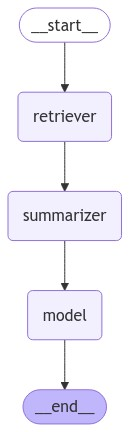

In [9]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)